In [16]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

from pa_lib.job import request_job
from pa_lib.file import project_dir, load_bin, load_csv
from pa_lib.data import desc_col
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import statsmodels.api as sm
import numpy as np
from pa_lib.vis import boxplot_histogram

import seaborn as sns

import urlopen

sns.set_style("darkgrid")

import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"
import plotly.express as px

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import os

C:\Users\stc\Documents\GitHub\DataScienceAPG\PredictiveAnalyticsPython\stc
C:\Users\stc\Documents\GitHub\DataScienceAPG\PredictiveAnalyticsPython


# Global Variables

In [17]:
BASELINE_DATE = pd.to_datetime("13.01.2020",format="%d.%m.%Y")
LOCKDOWN_DATE = pd.to_datetime("13.3.2020",format="%d.%m.%Y")
display(LOCKDOWN_DATE)

Timestamp('2020-03-13 00:00:00')

# Load data

In [18]:
DATA_DIR = Path.home() / "data" / "dashboard-corona"

In [19]:
DATA_DIR

WindowsPath('C:/Users/stc/data/dashboard-corona')

In [20]:
apple_df = pd.read_feather(DATA_DIR / "apple_mobility_data.feather")
zh_hardbruecke_df = pd.read_feather(DATA_DIR / "hardbruecke_data.feather")
zh_fussvelo_df = pd.read_feather(DATA_DIR / "passanten_velo_sum.feather")
zh_auto_df = pd.read_feather(DATA_DIR / "verkehrsdaten_median.feather")


In [21]:
container_df = apple_df.loc[
    apple_df.region.isin(["Zurich","Switzerland"]),
    ["date","region","transportation_type", "percent"]
].rename(columns={
    "percent": "apple_percent",
    "transportation_type": "type"}
        ).eval("apple_percent = apple_percent - 100")

container_df = (pd.pivot_table(container_df,
               values="apple_percent",
               columns="region",
               index=["date","type"])
           .reset_index()
           .rename(columns={"Switzerland": "apple_ch_percent",
                            "Zurich": "apple_zh_percent"})
           .rename_axis(None,inplace=False))

In [22]:
zh_transit_df = zh_hardbruecke_df.loc[:,["Date", "Trend"]].rename(
    columns={"Date": "date","Trend": "zh_percent"})
zh_transit_df.loc[:,"type"] = "transit"

zh_walking_df = zh_fussvelo_df.loc[:,["date","trend"]].rename(
    columns={"trend": "zh_percent"}
)
zh_walking_df.loc[:,"type"] = "walking"

auto_baseline_value = (zh_auto_df.loc[
    zh_auto_df.date == BASELINE_DATE,
    "AnzFahrzeuge"].values[0]
                      )
zh_auto_series = ((zh_auto_df.AnzFahrzeuge - auto_baseline_value)
                  / auto_baseline_value *100)

zh_driving_df = pd.DataFrame({"date": zh_auto_df.date, "zh_percent": zh_auto_series, "type": "driving"})

zh_fusion_df = pd.concat([zh_transit_df,zh_walking_df, zh_driving_df]).astype({"date": "datetime64[ns]"})

In [23]:
combination_df = pd.merge(container_df,
                          zh_fusion_df, 
                          left_on=["date","type"],
                          right_on=["date","type"],
                          how="left")
lockdown_flag= (combination_df.date > LOCKDOWN_DATE)

combination_df.loc[:,"lockdown_flag"] = lockdown_flag

In [24]:
combination_df.loc[combination_df.zh_percent.isna()]


,date,type,apple_ch_percent,apple_zh_percent,zh_percent,lockdown_flag
95,2020-02-13,walking,9.24,3.48,NaN,False
98,2020-02-14,walking,28.90,21.96,NaN,False
101,2020-02-15,walking,36.98,26.49,NaN,False
104,2020-02-16,walking,-4.71,-14.32,NaN,False
107,2020-02-17,walking,5.70,-2.37,NaN,False


In [25]:
combination_df.sample(200)

,date,type,apple_ch_percent,apple_zh_percent,zh_percent,lockdown_flag
83,2020-02-09,walking,-9.35,-14.12,-35.325874,False
138,2020-02-28,driving,14.60,13.06,17.786561,False
323,2020-04-29,walking,-34.97,-33.05,-43.455536,True
67,2020-02-04,transit,6.37,4.39,1.224859,False
19,2020-01-19,transit,-1.38,-6.17,-48.409040,False
...,...,...,...,...,...,...
311,2020-04-25,walking,-27.78,-21.44,-24.701855,True
294,2020-04-20,driving,-31.52,-26.26,-26.877470,True
205,2020-03-21,transit,-77.76,-75.56,-78.020339,True
352,2020-05-09,transit,-54.84,-53.89,-48.662147,True


# Simple lineplot

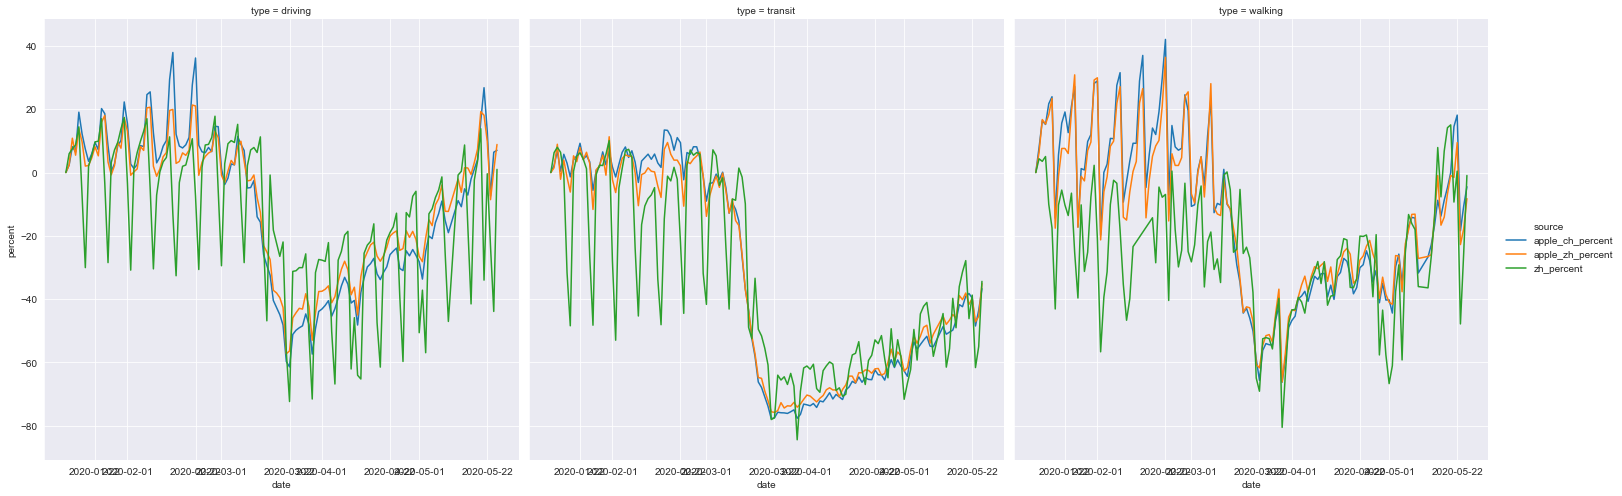

In [26]:
plot_data = (combination_df.melt(id_vars=["date","type","lockdown_flag"])
             .rename(columns={"variable":"source", "value": "percent"})
            )

sns.relplot(x="date",
            y="percent",
            hue="source",
            col="type",
            kind="line",
            data=plot_data,
            col_wrap=3,
            height=7)

# Correlation

https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9


In [27]:
(combination_df.groupby(["type","lockdown_flag"]).corr(method="pearson",)*100).style.format('{0:,.1f}')

In [28]:
(combination_df[combination_df.date > LOCKDOWN_DATE].drop(columns=["lockdown_flag"])
 .groupby("type")
 .corr(method="pearson"))

apple_ch_percent  apple_zh_percent  zh_percent
type                                                                    
driving apple_ch_percent          1.000000          0.991297    0.553507
        apple_zh_percent          0.991297          1.000000    0.600626
        zh_percent                0.553507          0.600626    1.000000
transit apple_ch_percent          1.000000          0.992894    0.783850
        apple_zh_percent          0.992894          1.000000    0.787997
        zh_percent                0.783850          0.787997    1.000000
walking apple_ch_percent          1.000000          0.976309    0.825007
        apple_zh_percent          0.976309          1.000000    0.849530
        zh_percent                0.825007          0.849530    1.000000

In [29]:
combination_df.corr(method="pearson")

,apple_ch_percent,apple_zh_percent,zh_percent,lockdown_flag
apple_ch_percent,1.000000,0.991781,0.797765,-0.795413
apple_zh_percent,0.991781,1.000000,0.823188,-0.764821
zh_percent,0.797765,0.823188,1.000000,-0.603994
lockdown_flag,-0.795413,-0.764821,-0.603994,1.000000


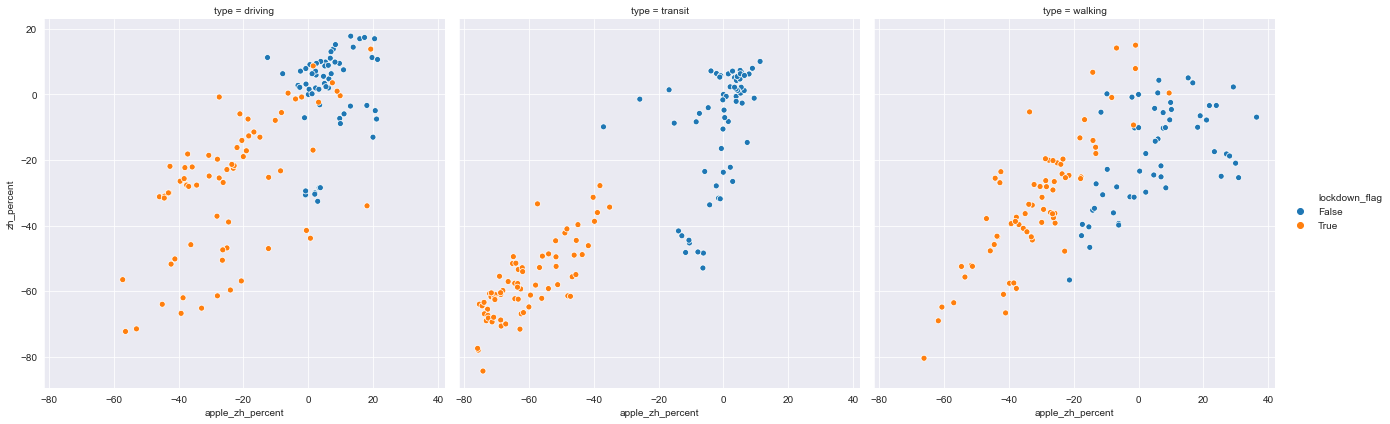

In [30]:
sns.relplot(x="apple_zh_percent",
            y="zh_percent",
            col="type",
            hue="lockdown_flag",
            data=combination_df,
            col_wrap=3,
            height=6)

False
True


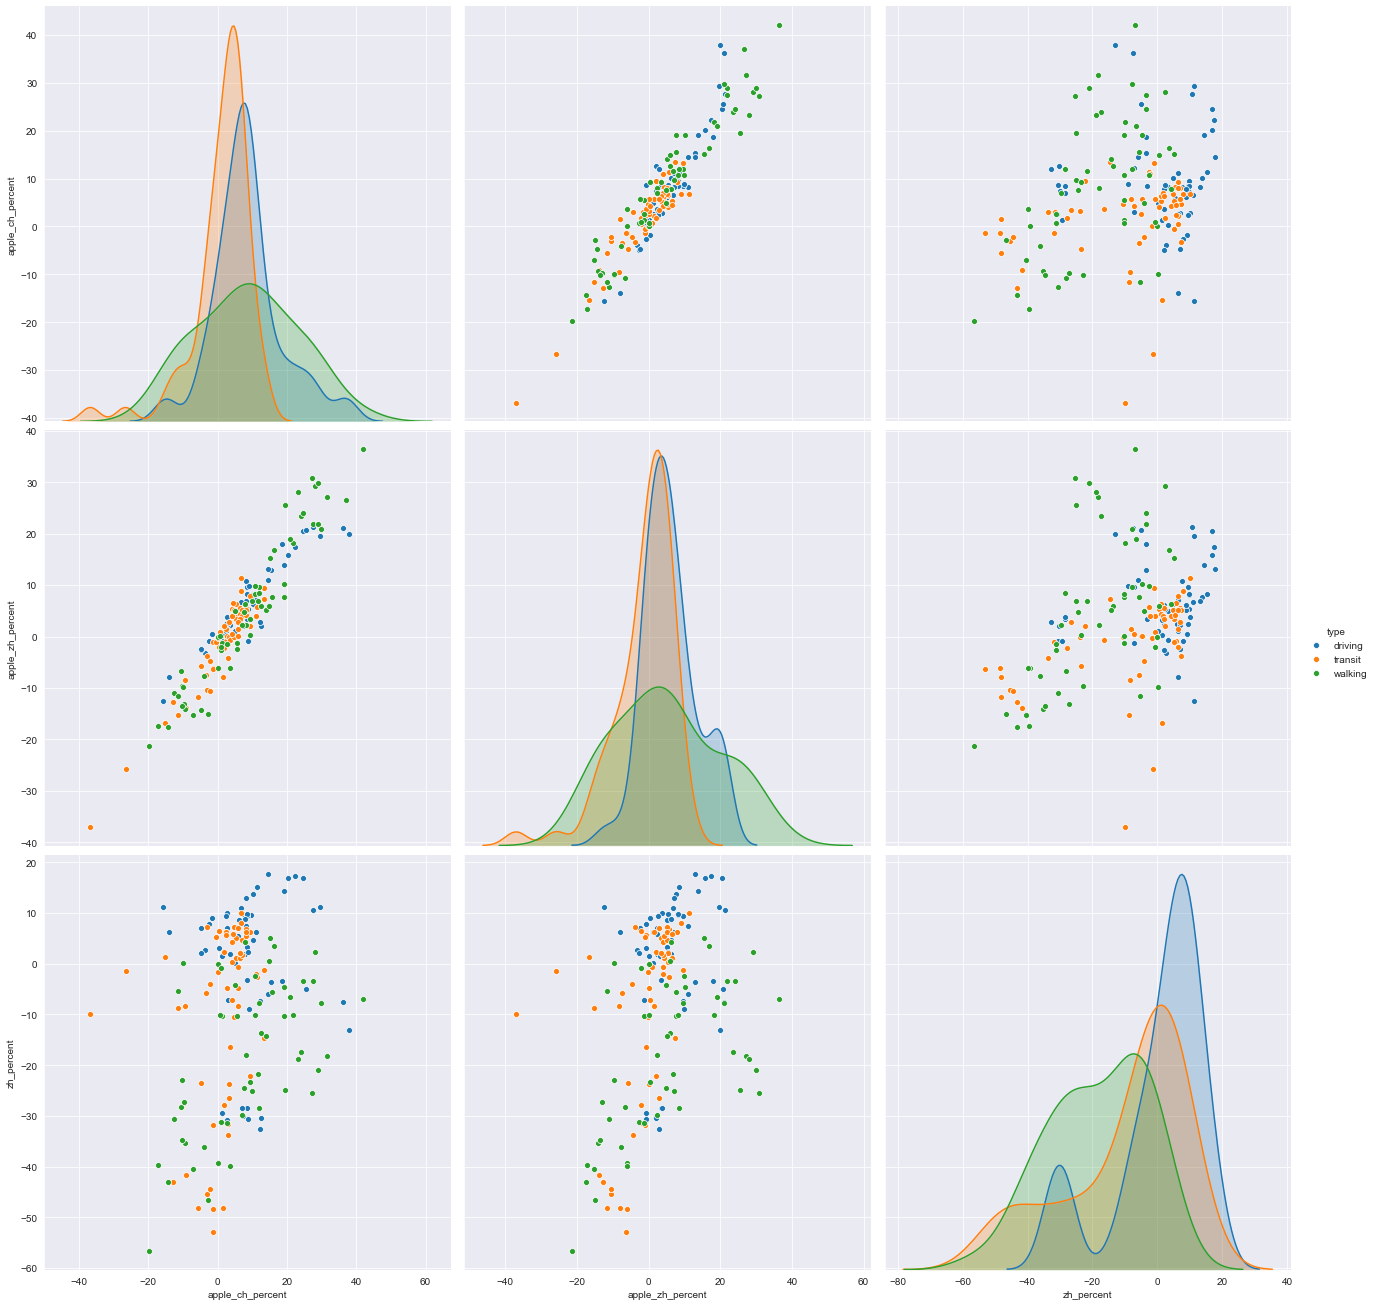

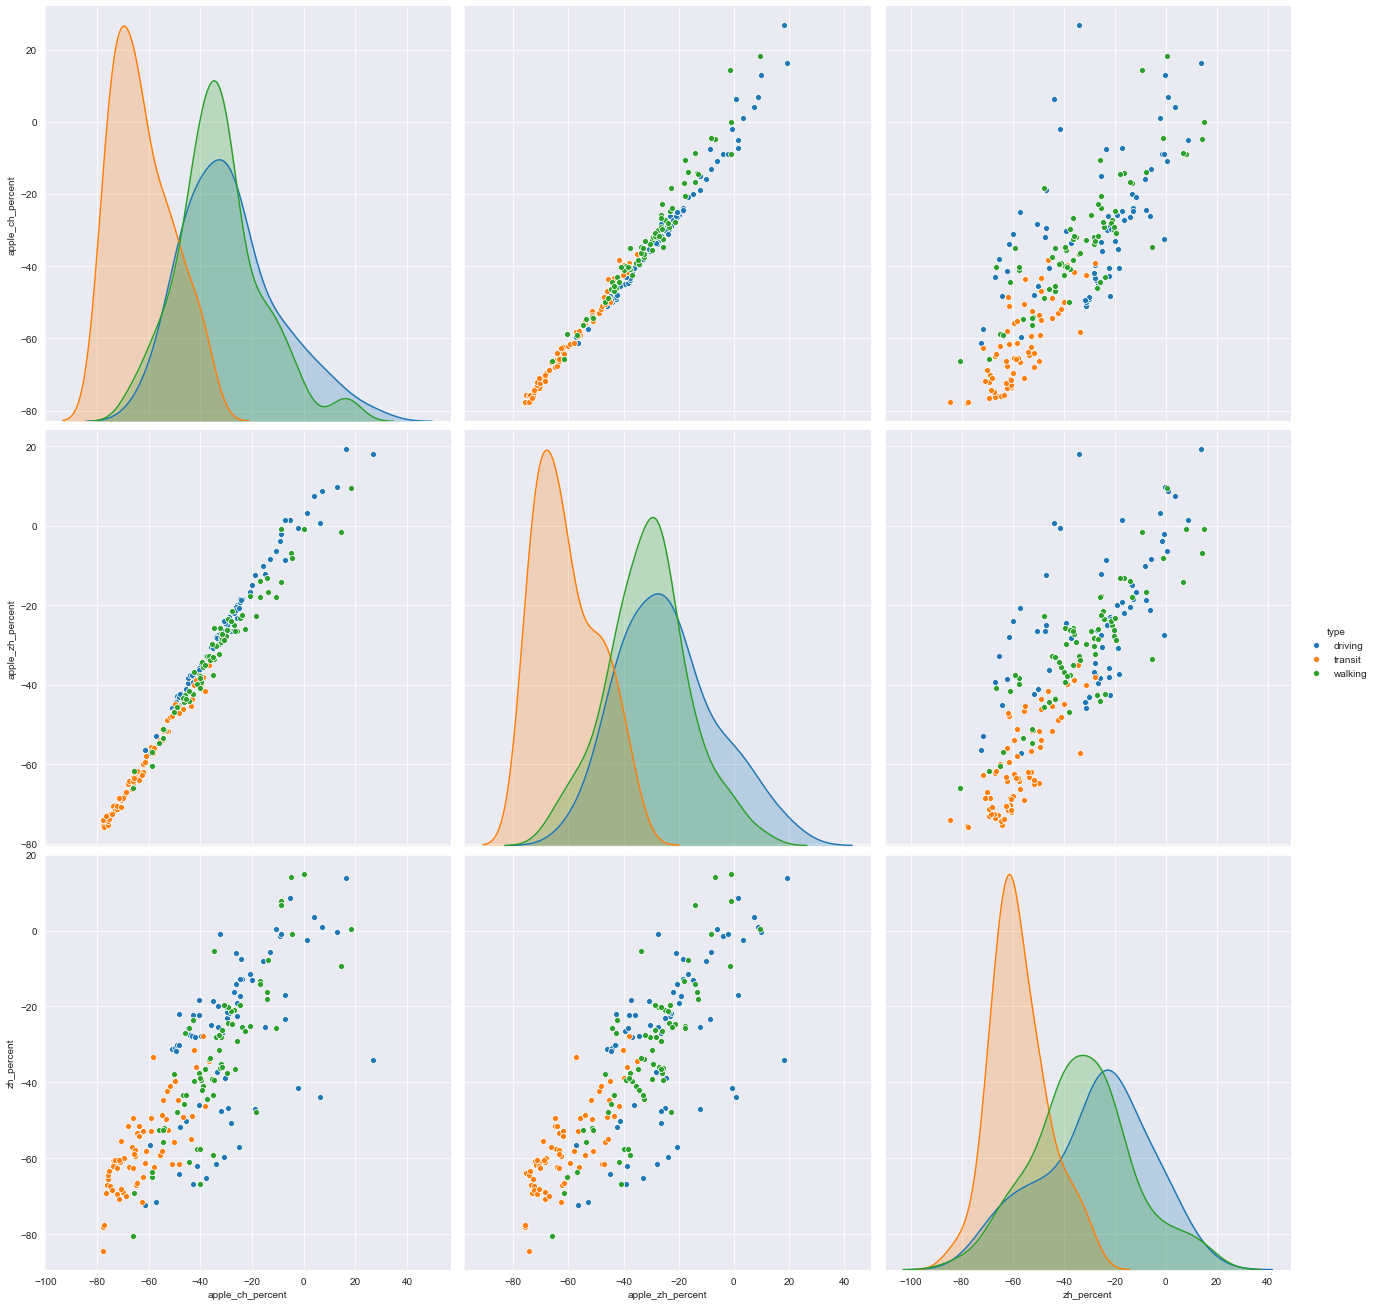

In [32]:
for flag,plot_data in combination_df.groupby("lockdown_flag"):
    print(flag)
    sns.pairplot(plot_data.drop(columns="lockdown_flag"),hue="type",height=6,)

# Seasonal Decomposition

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/


In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

## Additive Decomposition

In [34]:
combination_melted_df = (combination_df.melt(id_vars=["date","type","lockdown_flag"])
             .rename(columns={"variable":"source", "value": "percent"})
            ).sort_values("date")

grouped_dataset = combination_melted_df.groupby(["type","source"])

seasonal_decomposition_df = pd.DataFrame()
for x in grouped_dataset:
    temp_df = x[1].copy()
    temp_df.loc[:,"type"]= x[0][0]
    temp_df.loc[:,"source"] = x[0][1]

    observations = temp_df.percent
    observations_imputated = observations.fillna(observations.shift(7))
    
    result = seasonal_decompose(observations_imputated, model='additive', period=7,extrapolate_trend="freq")
    
    temp_df.loc[:,"trend"] = result.trend
    temp_df.loc[:,"seasonal"] = result.seasonal
    temp_df.loc[:,"residues"] = result.resid
    temp_df.loc[:,"trend_plus_seasonal"] = result.seasonal + result.trend
    
    seasonal_decomposition_df = pd.concat([seasonal_decomposition_df,temp_df])

In [35]:
seasonal_decomposition_df

,date,type,lockdown_flag,source,percent,trend,seasonal,residues,trend_plus_seasonal
0,2020-01-13,driving,False,apple_ch_percent,0.000000,7.054898,-2.676935,-4.377963,4.377963
3,2020-01-14,driving,False,apple_ch_percent,2.350000,7.392143,-1.203331,-3.838811,6.188811
6,2020-01-15,driving,False,apple_ch_percent,8.160000,7.729388,1.032979,-0.602367,8.762367
9,2020-01-16,driving,False,apple_ch_percent,6.470000,7.942857,-1.080147,-0.392711,6.862711
12,2020-01-17,driving,False,apple_ch_percent,19.060000,8.450000,5.214837,5.395163,13.664837
...,...,...,...,...,...,...,...,...,...
1175,2020-05-21,walking,True,zh_percent,-9.330830,-6.632979,-3.267217,0.569366,-9.900196
1178,2020-05-22,walking,True,zh_percent,0.435561,-7.732136,4.864518,3.303179,-2.867618
1181,2020-05-23,walking,True,zh_percent,-47.823420,2.670966,4.586937,-55.081323,7.257903
1184,2020-05-24,walking,True,zh_percent,-25.672360,4.026846,5.622131,-35.321337,9.648977


In [109]:
seasonal_decomposition_df[seasonal_decomposition_df.date.isin(["2020-01-13","2020-01-14"])]

,date,type,lockdown_flag,source,percent,trend,seasonal,residues,trend_plus_seasonal
0,2020-01-13,driving,False,apple_ch_percent,0.000000,7.054898,-2.676935,-4.377963,4.377963
3,2020-01-14,driving,False,apple_ch_percent,2.350000,7.392143,-1.203331,-3.838811,6.188811
396,2020-01-13,driving,False,apple_zh_percent,0.000000,5.748776,-1.780004,-3.968771,3.968771
399,2020-01-14,driving,False,apple_zh_percent,2.380000,5.931633,-0.599403,-2.952230,5.332230
792,2020-01-13,driving,False,zh_percent,0.000000,-0.969993,4.364472,-3.394479,3.394479
795,2020-01-14,driving,False,zh_percent,5.928854,-0.720941,6.765997,-0.116203,6.045057
1,2020-01-13,transit,False,apple_ch_percent,0.000000,1.671429,0.631421,-2.302850,2.302850
4,2020-01-14,transit,False,apple_ch_percent,2.260000,1.995918,0.880508,-0.616427,2.876427
397,2020-01-13,transit,False,apple_zh_percent,0.000000,-0.526020,1.007180,-0.481159,0.481159
400,2020-01-14,transit,False,apple_zh_percent,1.510000,-0.109235,0.938627,0.680607,0.829393


## Simple lineplot

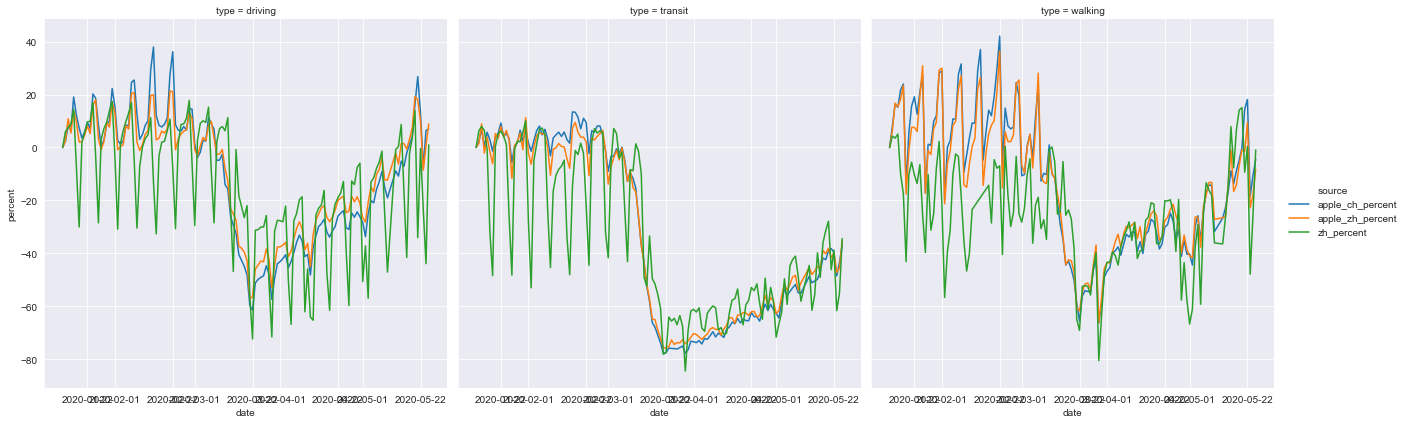

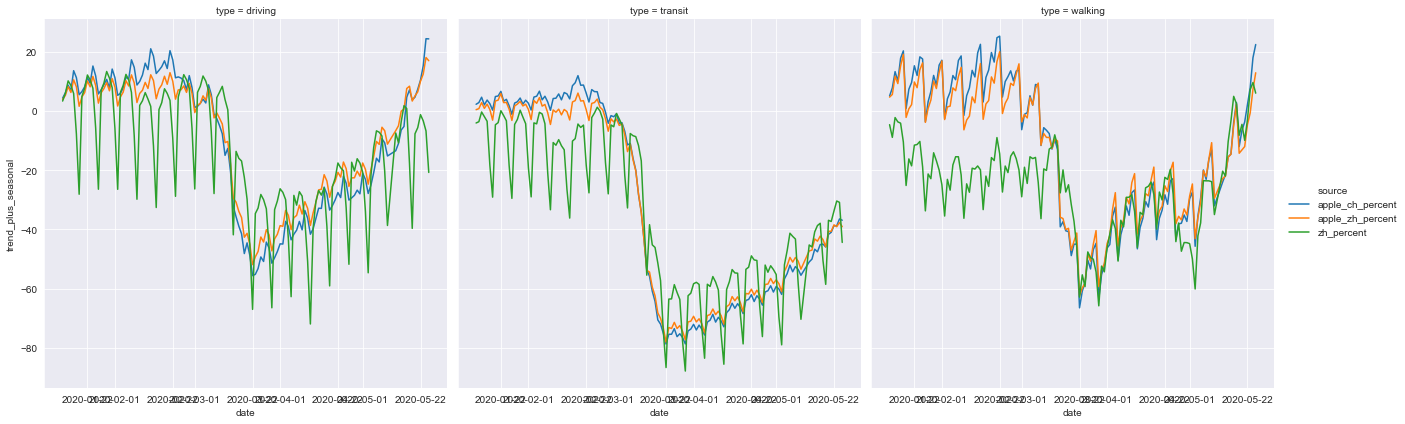

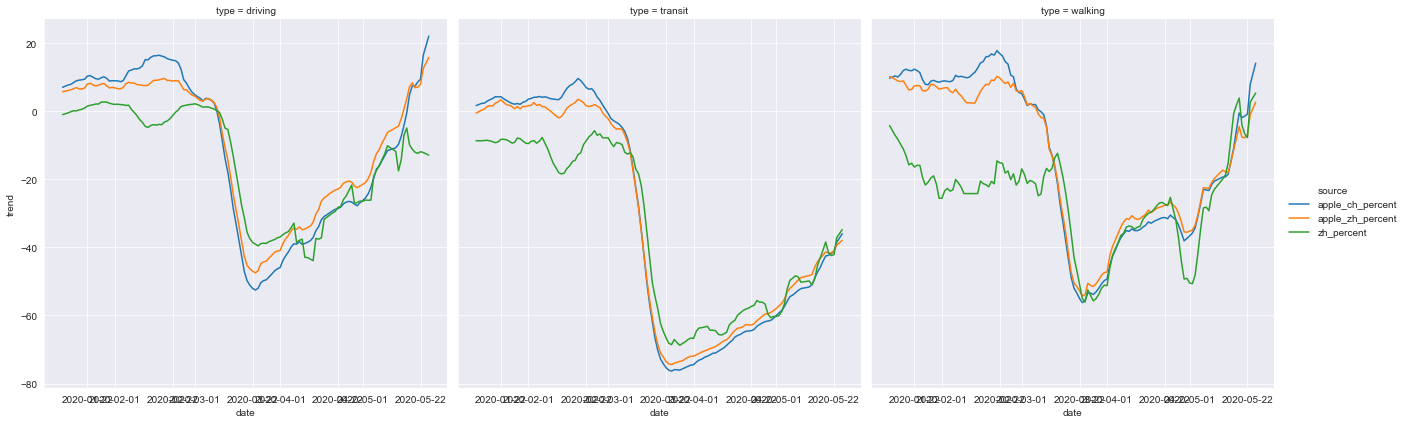

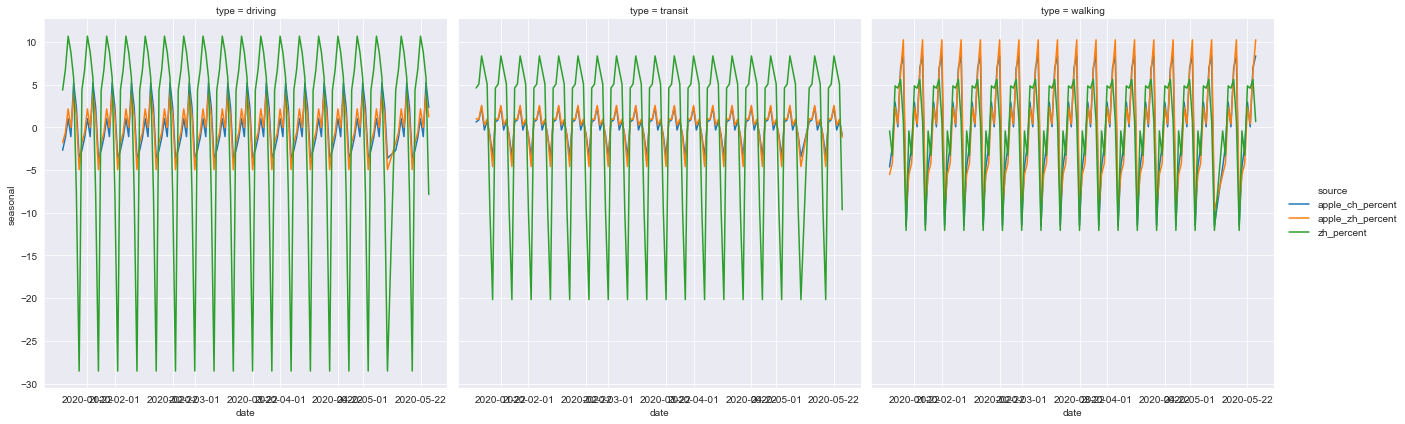

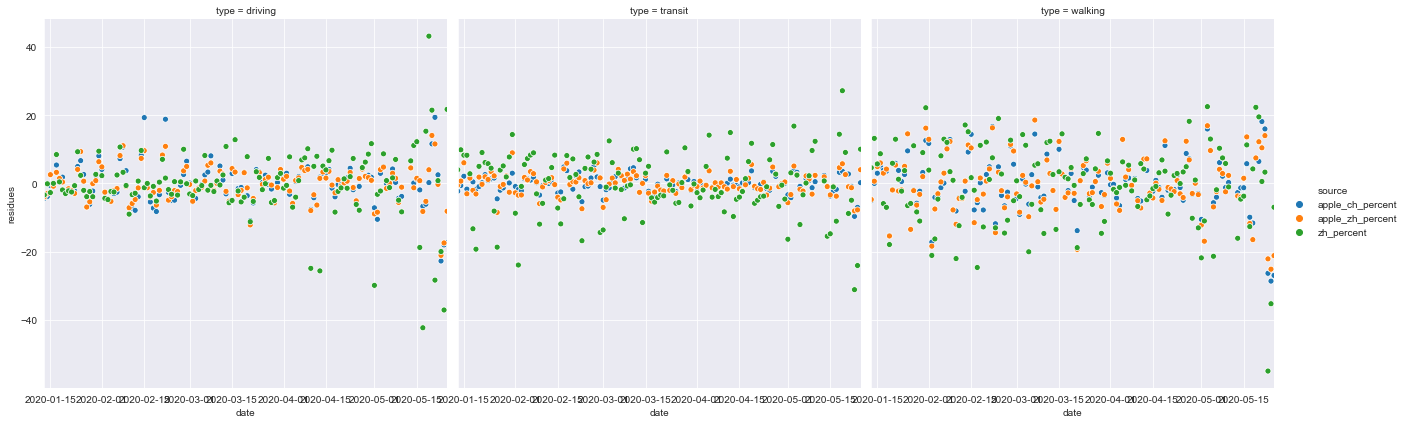

In [36]:
for y_values in ["percent","trend_plus_seasonal","trend","seasonal"]:
    sns.relplot(x="date",
            y=y_values,
            hue="source",
            col="type",
            kind="line",
            data=seasonal_decomposition_df,
            col_wrap=3,
            height=6)

g= sns.relplot(x="date",
            y="residues",
            hue="source",
            col="type",
            kind="scatter",
            data=seasonal_decomposition_df,
            col_wrap=3,
            height=6)
axes_ = g.axes
for x in [0,1,2]:
    axes_[x].set_xlim(seasonal_decomposition_df.date.min(),seasonal_decomposition_df.date.max())

In [117]:
from scipy.stats import zscore

c:\users\stc\envs\datascience-dev\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\stc\envs\datascience-dev\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



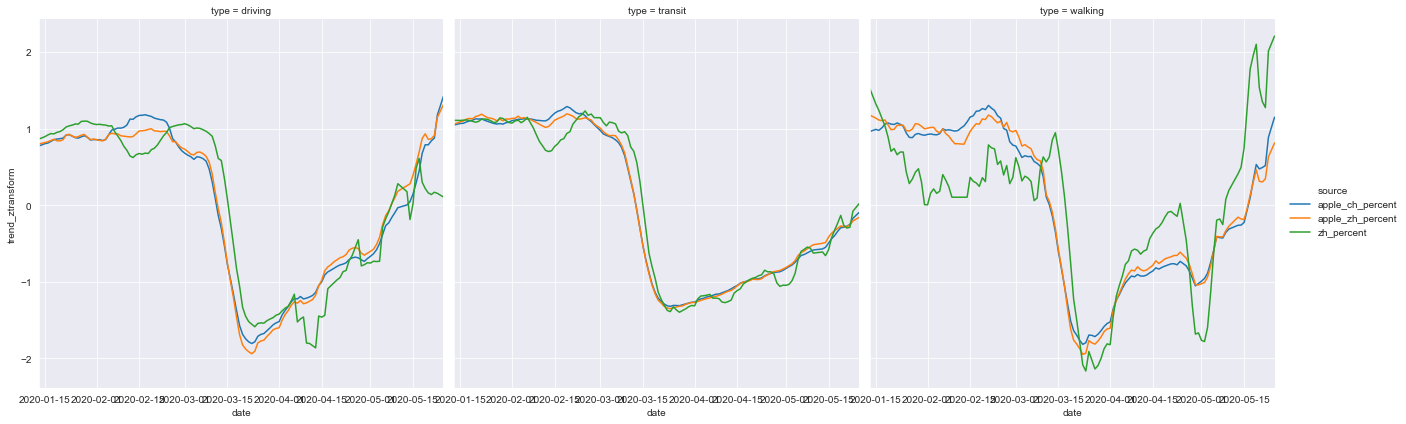

In [134]:
trend_manipulation = seasonal_decomposition_df.copy()
container_df = pd.DataFrame()
for a, b in trend_manipulation.groupby(["type","source"]):
    b.loc[:,"trend_ztransform"] = zscore(b.trend).copy()
    container_df = pd.concat([container_df,b])

seasonal_decomposition_plus_ztransform = container_df.copy()
    
g = sns.relplot(x="date",
            y="trend_ztransform",
            hue="source",
            col="type",
            kind="line",
            data=seasonal_decomposition_plus_ztransform,
            col_wrap=3,
            height=6)
axes_ = g.axes
for x in [0,1,2]:
    axes_[x].set_xlim(seasonal_decomposition_df.date.min(),seasonal_decomposition_df.date.max())

In [135]:
seasonal_decomposition_plus_ztransform

,date,type,lockdown_flag,source,percent,trend,seasonal,residues,trend_plus_seasonal,trend_ztransform
0,2020-01-13,driving,False,apple_ch_percent,0.000000,7.054898,-2.676935,-4.377963,4.377963,0.774004
3,2020-01-14,driving,False,apple_ch_percent,2.350000,7.392143,-1.203331,-3.838811,6.188811,0.788600
6,2020-01-15,driving,False,apple_ch_percent,8.160000,7.729388,1.032979,-0.602367,8.762367,0.803196
9,2020-01-16,driving,False,apple_ch_percent,6.470000,7.942857,-1.080147,-0.392711,6.862711,0.812435
12,2020-01-17,driving,False,apple_ch_percent,19.060000,8.450000,5.214837,5.395163,13.664837,0.834385
...,...,...,...,...,...,...,...,...,...,...
1175,2020-05-21,walking,True,zh_percent,-9.330830,-6.632979,-3.267217,0.569366,-9.900196,1.353523
1178,2020-05-22,walking,True,zh_percent,0.435561,-7.732136,4.864518,3.303179,-2.867618,1.275336
1181,2020-05-23,walking,True,zh_percent,-47.823420,2.670966,4.586937,-55.081323,7.257903,2.015349
1184,2020-05-24,walking,True,zh_percent,-25.672360,4.026846,5.622131,-35.321337,9.648977,2.111798


# Differences 

In [136]:
container_df = pd.DataFrame()
for _type_ in ["driving","walking","transit"]:
    temp_df = seasonal_decomposition_plus_ztransform.loc[
        (seasonal_decomposition_df.type == _type_) & 
        (seasonal_decomposition_df.source.isin(["apple_zh_percent","zh_percent"]) ),
        ["date", "source", "trend","trend_ztransform"]
    ]
    temp_df = pd.pivot_table(
        temp_df,
        values="trend_ztransform",
        columns=["source"],
        index="date"
    ).reset_index()
    
    temp_df.loc[:,f"difference"]= temp_df.apple_zh_percent - temp_df.zh_percent
    temp_df.loc[:,"type"] = _type_
    
    container_df = pd.concat([container_df,temp_df])
    

In [156]:
from statsmodels.tsa.stattools import kpss, adfuller

In [161]:
from scipy.stats import wilcoxon


driving
Kwiatkowski-Phillips-Schmidt-Shin test:
p_value: 0.08706555567495758
(0.3770079108340984, 0.08706555567495758, 13, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
Augmented Dickey-Fuller test
(-0.8924140558677083, 0.33197839497067827, 12, 119, {'1%': -2.5847843612739214, '5%': -1.9434762390967262, '10%': -1.6147646689600208}, -209.41187371275606)
Wilcoxon signed-rank test
WilcoxonResult(statistic=4183.0, pvalue=0.6398683749743247)


transit
Kwiatkowski-Phillips-Schmidt-Shin test:
p_value: 0.1
(0.10126401048359825, 0.1, 13, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
Augmented Dickey-Fuller test
(-2.557613081097846, 0.010201730996756666, 8, 123, {'1%': -2.5841569740233985, '5%': -1.9433893816162038, '10%': -1.6148264107751924}, -394.85642996482875)
Wilcoxon signed-rank test
WilcoxonResult(statistic=3938.0, pvalue=0.30567214105740415)


walking
Kwiatkowski-Phillips-Schmidt-Shin test:
p_value: 0.024562620922213427
(0.5788111698556523, 0.024562620922213427, 13

c:\users\stc\envs\datascience-dev\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning:

p-value is greater than the indicated p-value

c:\users\stc\envs\datascience-dev\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning:

p-value is greater than the indicated p-value



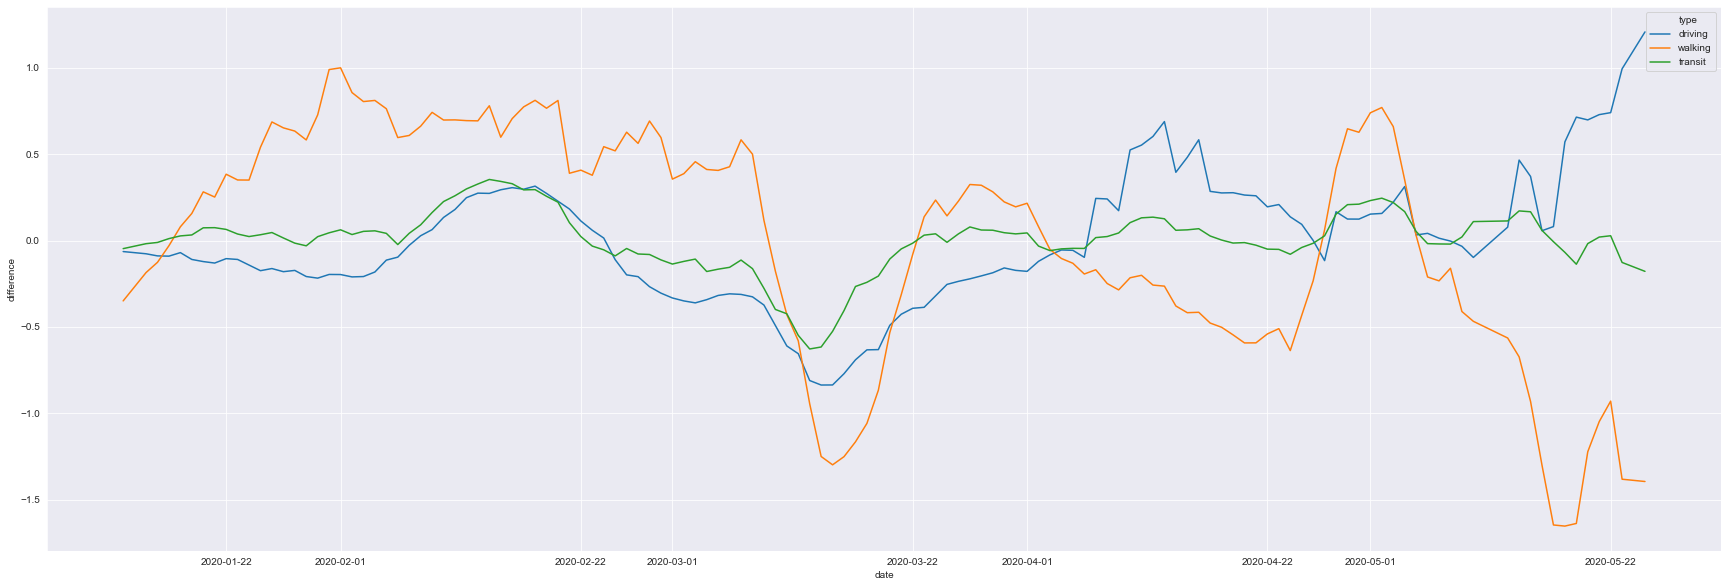

In [164]:
plt.figure(figsize=(30,10))
sns.lineplot(x="date",
            y="difference",
            hue="type",
            data=container_df,
            )

for a,b in container_df.groupby(["type"]):
    print(a)
    print("Kwiatkowski-Phillips-Schmidt-Shin test:")
    print(f"p_value: {kpss(b.difference,nlags='legacy')[1]}")
    print(f"{kpss(b.difference,nlags='legacy')}")
    print("Augmented Dickey-Fuller test")
    print(adfuller(b.difference,regression="nc"))
    print("Wilcoxon signed-rank test")
    print(wilcoxon(x=b.difference, zero_method="wilcox", alternative="two-sided"))
    print("\n")
    

## Correlation on Trend

In [37]:
correlate_this = (pd.pivot_table(seasonal_decomposition_df,
                values="trend",
                columns=["source"],
                index=['date', 'type', 'lockdown_flag'])
 .reset_index()
)

(correlate_this.drop(columns="lockdown_flag")
 .groupby("type")
 .corr(method="pearson")*100).style.format('{0:,.0f}')

# Granger Causality Test

- https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html#statsmodels.tsa.stattools.grangercausalitytests

- https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [38]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

In [39]:
print("H0: apple_zh_percent does not granger-cause zh_percent")
for _type_ in ["driving", "transit", "walking"]:
    percent_changes_df = (correlate_this
              .loc[correlate_this.type == _type_,
                   ['zh_percent', 'apple_zh_percent']
                  ].pct_change().dropna()
             )
    percent_changes_df = percent_changes_df[percent_changes_df < np.inf].dropna()
    print(f"\n{_type_}: {(percent_changes_df.shape[0])} days")
    granger_result = grangercausalitytests(percent_changes_df,maxlag=1)

H0: apple_zh_percent does not granger-cause zh_percent

driving: 131 days

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0855  , p=0.7704  , df_denom=127, df_num=1
ssr based chi2 test:   chi2=0.0876  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7673  , df=1
parameter F test:         F=0.0855  , p=0.7704  , df_denom=127, df_num=1

transit: 131 days

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3697  , p=0.5443  , df_denom=127, df_num=1
ssr based chi2 test:   chi2=0.3784  , p=0.5385  , df=1
likelihood ratio test: chi2=0.3778  , p=0.5388  , df=1
parameter F test:         F=0.3697  , p=0.5443  , df_denom=127, df_num=1

walking: 131 days

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2499  , p=0.6180  , df_denom=127, df_num=1
ssr based chi2 test:   chi2=0.2558  , p=0.6130  , df=1
likelihood ratio test: chi2=0.2555  , p=0.6132  , df=1
parameter F test:         F=0.2499  , p=0.6180  , df_de

# Testing 

In [40]:
test = (pd.Series(range(0,7)) + 1).append((pd.Series(range(0,7)) + 1)).reset_index().drop(columns="index").copy()
test.loc[:,"shift"] = test.loc[:,0].shift(-1)
blah = grangercausalitytests(test.dropna(),maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=78434267280923841492946018893824.0000, p=0.0000  , df_denom=9, df_num=1
ssr based chi2 test:   chi2=104579023041231794662060861685760.0000, p=0.0000  , df=1
likelihood ratio test: chi2=854.9111, p=0.0000  , df=1
parameter F test:         F=78434267280923832485746764152832.0000, p=0.0000  , df_denom=9, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=611935419504898848755665600512.0000, p=0.0000  , df_denom=7, df_num=2
ssr based chi2 test:   chi2=1923225604158253564871374274560.0000, p=0.0000  , df=2
likelihood ratio test: chi2=740.6703, p=0.0000  , df=2
parameter F test:         F=738354874630983768420542054400.0000, p=0.0000  , df_denom=7, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=418481685164504698401847246848.0000, p=0.0000  , df_denom=5, df_num=3
ssr based chi2 test:   chi2=2510890110987028753361036902400.0000, p=0.0000  , df=3
likelih